In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error


In [2]:
try:
    # Read sales training data file train.csv
    sales_train_df = pd.read_csv('train.csv', low_memory=False)
    
    # Read store information file store.csv
    store_info_df = pd.read_csv('store.csv', low_memory=False)
    
    # Notify if loaded successfully
    print("Successfully loaded original data.")
    
except FileNotFoundError:
    # If file not found, create mock data
    print("File not found, creating mock data.")
    
    # Create mock sales data
    sales_data = {
        'Store': [1]*10 + [2]*10,  # Store ID (1 or 2)
        'DayOfWeek': [5,4,3,2,1,5,4,3,2,1]*2,  # Day of the week
        'Date': pd.date_range(start='2015-07-01', periods=10).tolist() * 2,  # Sales date
        'Sales': [5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,
                  6000,6500,8500,14000,5000,5800,15500,8600,8700,7300],  # Sales revenue
        'Customers': [555,625,821,1498,559,589,1414,833,687,681,
                      600,650,830,1500,560,590,1420,840,690,685],  # Number of customers
        'Open': [1]*20,  # Store open (1) or closed (0)
        'Promo': [1,1,1,1,1,0,0,0,0,0]*2,  # Running a promotion or not
        'StateHoliday': ['0']*20,  # State holiday
        'SchoolHoliday': [1]*20  # School holiday
    }
    
    # Create mock store information
    store_info_data = {
        'Store': [1, 2],  # Store ID
        'StoreType': ['c', 'a'],  # Store type
        'Assortment': ['a', 'a'],  # Assortment level
        'CompetitionDistance': [1270.0, 570.0],  # Distance to nearest competitor
        'CompetitionOpenSinceMonth': [9.0, 11.0],  # Month when competition started
        'CompetitionOpenSinceYear': [2008.0, 2007.0],  # Year when competition started
        'Promo2': [0, 1],  # Whether running continuous promotion
        'Promo2SinceWeek': [np.nan, 13.0],  # Week when Promo2 started
        'Promo2SinceYear': [np.nan, 2010.0],  # Year when Promo2 started
        'PromoInterval': [np.nan, 'Jan,Apr,Jul,Oct']  # Months of recurring promotion
    }
    
    # Convert mock data into DataFrame
    sales_train_df = pd.DataFrame(sales_data)
    store_info_df = pd.DataFrame(store_info_data)

# Display first 5 rows of sales data
print(sales_train_df.head())


File not found, creating mock data.
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-01   5263        555     1      1            0   
1      1          4 2015-07-02   6064        625     1      1            0   
2      1          3 2015-07-03   8314        821     1      1            0   
3      1          2 2015-07-04  13995       1498     1      1            0   
4      1          1 2015-07-05   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  


In [3]:
# Merge sales data with store info
sales_train_all_df = pd.merge(sales_train_df, store_info_df, on='Store', how='inner')

# Handle missing values
sales_train_all_df['CompetitionDistance'].fillna(sales_train_all_df['CompetitionDistance'].median(), inplace=True)
for col in ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']:
    sales_train_all_df[col].fillna(0, inplace=True)

# Convert Date to datetime format
sales_train_all_df['Date'] = pd.to_datetime(sales_train_all_df['Date'])

# Remove rows where store was closed or sales = 0
sales_train_all_df = sales_train_all_df[(sales_train_all_df['Open'] == 1) & (sales_train_all_df['Sales'] > 0)]
sales_train_all_df.drop(['Open'], axis=1, inplace=True)

# Show first 5 rows
print(sales_train_all_df.head())


   Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
0      1          5 2015-07-01   5263        555      1            0   
1      1          4 2015-07-02   6064        625      1            0   
2      1          3 2015-07-03   8314        821      1            0   
3      1          2 2015-07-04  13995       1498      1            0   
4      1          1 2015-07-05   4822        559      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0

C:\Users\Admin\AppData\Local\Temp\ipykernel_5728\1772940498.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_train_all_df['CompetitionDistance'].fillna(sales_train_all_df['CompetitionDistance'].median(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_5728\1772940498.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      20 non-null     int64         
 1   DayOfWeek                  20 non-null     int64         
 2   Date                       20 non-null     datetime64[ns]
 3   Sales                      20 non-null     int64         
 4   Customers                  20 non-null     int64         
 5   Promo                      20 non-null     int64         
 6   StateHoliday               20 non-null     object        
 7   SchoolHoliday              20 non-null     int64         
 8   StoreType                  20 non-null     object        
 9   Assortment                 20 non-null     object        
 10  CompetitionDistance        20 non-null     float64       
 11  CompetitionOpenSinceMonth  20 non-null     float64       
 12  Competitio

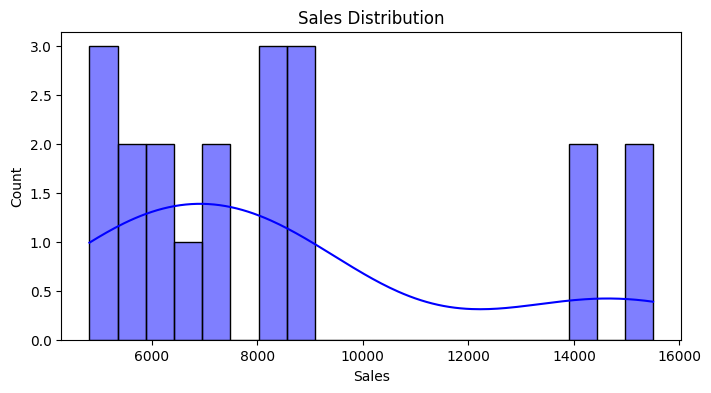

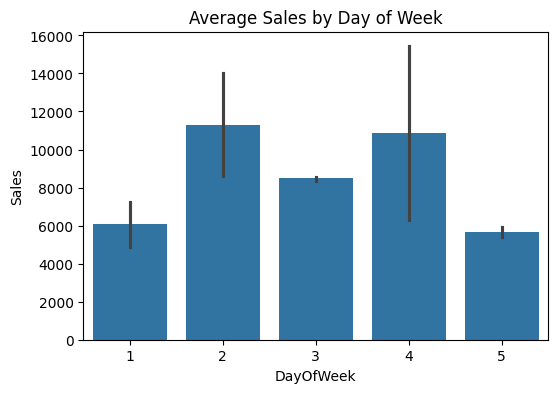

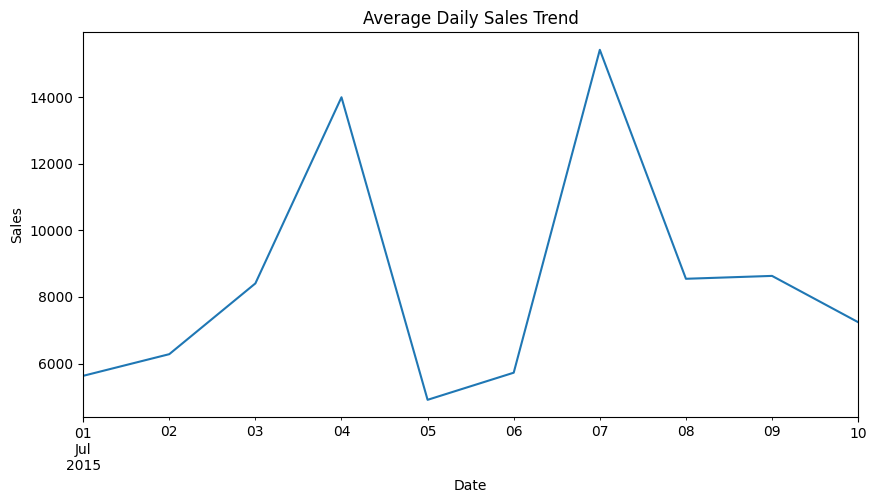

In [4]:
# View general information about the dataset (rows, columns, data types, null values, etc.)
print(sales_train_all_df.info())

# --- SALES DISTRIBUTION PLOT ---
plt.figure(figsize=(8,4))
# Plot a histogram with 20 bins and a KDE (density curve)
# X-axis: Sales values (e.g., 5000, 6000, ...)
# Y-axis: Frequency (count of occurrences of sales values in the dataset)
sns.histplot(sales_train_all_df['Sales'], bins=20, kde=True, color='blue')
plt.title('Sales Distribution')
plt.show()

# --- AVERAGE SALES BY DAY OF WEEK ---
plt.figure(figsize=(6,4))
# Plot a bar chart with average values (estimator=np.mean)
# X-axis: Day of the week (DayOfWeek)
# Y-axis: Average sales (Sales)
sns.barplot(data=sales_train_all_df, x='DayOfWeek', y='Sales', estimator=np.mean)
plt.title('Average Sales by Day of Week')
plt.show()

# --- SALES TREND OVER TIME ---
plt.figure(figsize=(10,5))
# Group data by date ('Date'), calculate mean sales, and plot a line chart
sales_train_all_df.groupby('Date')['Sales'].mean().plot()
plt.title('Average Daily Sales Trend')
plt.ylabel('Sales')  # Y-axis label
plt.show()


In [5]:
# Add time features from the Date column
sales_train_all_df['Year'] = sales_train_all_df['Date'].dt.year       # Year of the sales date
sales_train_all_df['Month'] = sales_train_all_df['Date'].dt.month     # Month of the sales date
sales_train_all_df['Day'] = sales_train_all_df['Date'].dt.day         # Day of the month
sales_train_all_df['WeekOfYear'] = sales_train_all_df['Date'].dt.isocalendar().week.astype(int)  # Week number of the year

# One-hot encoding for categorical columns
categorical_features = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
sales_train_all_df = pd.get_dummies(sales_train_all_df, columns=categorical_features, drop_first=True)  
# drop_first=True to avoid redundant columns (reduce multicollinearity)

# Select feature columns (independent variables) and target column (dependent variable)
features = ['Store', 'DayOfWeek', 'Customers', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear', 'StoreType_b', 'StoreType_c',
            'StoreType_d', 'Assortment_b', 'Assortment_c', 'StateHoliday_a', 'StateHoliday_b',
            'StateHoliday_c', 'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
            'PromoInterval_Mar,Jun,Sept,Dec']
target = 'Sales'

# Ensure all feature columns exist (if missing, add and fill with 0)
for col in features:
    if col not in sales_train_all_df.columns:
        sales_train_all_df[col] = 0

# Reorder columns: Date + features + target
sales_train_all_df = sales_train_all_df[['Date'] + features + [target]]

# Function to create sequences for LSTM model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Take a segment of seq_length days as input X
        X.append(data.iloc[i:i+seq_length, 1:-1].values)  # Exclude Date column, exclude target column
        # Sales value at the next day is y
        y.append(data.iloc[i+seq_length, -1])
    return np.array(X), np.array(y)

# Set sequence length for prediction (7 days)
SEQUENCE_LENGTH = 7

# Scale data to range [0,1] to help LSTM learn better
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sales_train_all_df.drop(['Date'], axis=1).values)

# Create a new DataFrame with scaled data (keep column names, drop Date)
scaled_df = pd.DataFrame(scaled_data, columns=sales_train_all_df.columns[1:])

# Create X, y from scaled data
X, y = create_sequences(scaled_df, SEQUENCE_LENGTH)

# Print dataset shape to verify
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (13, 7, 25) y shape: (13,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1021 - val_loss: 0.8321
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0516 - val_loss: 0.7428
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0496 - val_loss: 0.6615
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0308 - val_loss: 0.5863
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0267 - val_loss: 0.5164
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0353 - val_loss: 0.4570
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0176 - val_loss: 0.4097
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0135 - val_loss: 0.3750
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0250 - val_loss: 0.3588
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0278 - val_loss: 0.3516
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0242 - val_loss: 0.3538
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0290 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step

RMSE: 4952.81


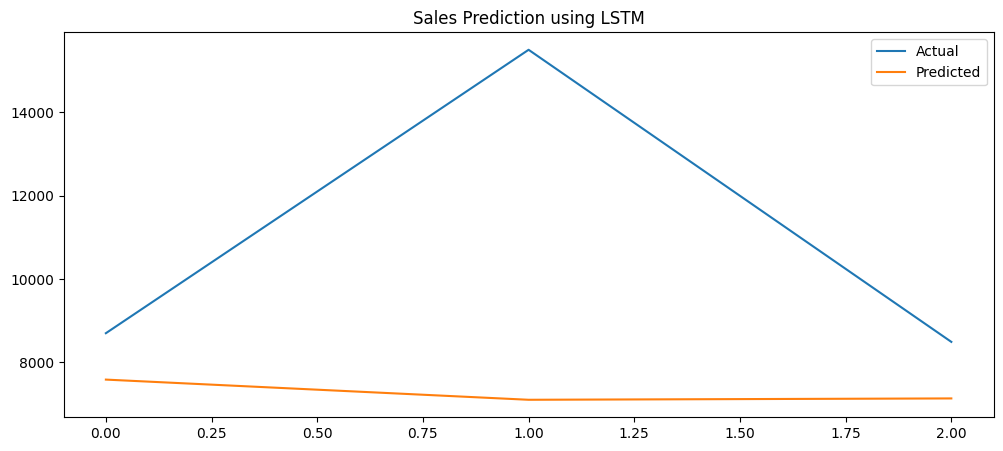

In [ ]:
predictions = model.predict(X_test)

# Inverse transform y_test (actual values)
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_test), scaled_data.shape[1]-1)), y_test.reshape(-1,1)])
)[:,-1]

# Inverse transform predictions
pred_inv = scaler.inverse_transform(
    np.hstack([np.zeros((len(predictions), scaled_data.shape[1]-1)), predictions])
)[:,-1]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
print(f"\nRMSE: {rmse:.2f}")

# Plot actual vs predicted sales
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred_inv, label='Predicted')
plt.legend()
plt.title('Sales Prediction using LSTM')
plt.show()
